## Import the necessary libraries

In [9]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import os  
print(os.getcwd())

c:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Model\RNN


## Load data

In [32]:
df = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\AMV Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,"3,700.0","3,600.0","3,800.0","3,600.0",1.44M,2.78%
1,05/30/2024,"3,600.0","3,600.0","3,800.0","3,500.0",3.23M,2.86%
2,05/29/2024,"3,500.0","3,500.0","3,600.0","3,500.0",522.68K,0.00%
3,05/28/2024,"3,500.0","3,500.0","3,600.0","3,500.0",452.54K,0.00%
4,05/27/2024,"3,500.0","3,500.0","3,600.0","3,500.0",660.47K,0.00%
...,...,...,...,...,...,...,...
1308,03/07/2019,"14,144.0","14,594.0","14,594.0","14,144.0",28.81K,-3.08%
1309,03/06/2019,"14,594.0","14,414.0","14,684.0","14,414.0",17.25K,1.25%
1310,03/05/2019,"14,414.0","14,865.0","15,045.0","14,414.0",48.80K,-3.03%
1311,03/04/2019,"14,865.0","15,180.0","15,180.0","14,865.0",19.01K,-2.36%


## Data preprocessing

In [33]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [34]:
# Show Dataframe
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,15225.0,15270.0,15315.0,15180.0,4.70K,-0.29%
2019-03-04,14865.0,15180.0,15180.0,14865.0,19.01K,-2.36%
2019-03-05,14414.0,14865.0,15045.0,14414.0,48.80K,-3.03%
2019-03-06,14594.0,14414.0,14684.0,14414.0,17.25K,1.25%
2019-03-07,14144.0,14594.0,14594.0,14144.0,28.81K,-3.08%
...,...,...,...,...,...,...
2024-05-27,3500.0,3500.0,3600.0,3500.0,660.47K,0.00%
2024-05-28,3500.0,3500.0,3600.0,3500.0,452.54K,0.00%
2024-05-29,3500.0,3500.0,3600.0,3500.0,522.68K,0.00%


## Scale Data

In [35]:
# Select 'Close' column
data = df['Price'].values

In [36]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [37]:
# Define the size of train, validation, test set
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

# Split the data into train, test, and validation sets
train_data = data_scaled[:train_size]
val_data = data_scaled[train_size:train_size + val_size]
test_data = data_scaled[train_size + val_size:]

## Create and add data into X, y

In [38]:
# Function to prepare data for LSTM
def add_data(data, sequence_length=60):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [39]:
# Prepare sequences
sequence_length = 60
train_last_windowsize = train_data[-sequence_length:]
val_last_windowsize = val_data[-sequence_length:]

val_data_extended = np.concatenate((train_last_windowsize, val_data), axis=0)
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_val, y_val = add_data(val_data_extended, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

In [40]:
# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Build Model

In [41]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [42]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=2)

Epoch 1/50
27/27 - 7s - 249ms/step - loss: 0.0528 - val_loss: 0.0136
Epoch 2/50
27/27 - 1s - 49ms/step - loss: 0.0154 - val_loss: 0.0014
Epoch 3/50
27/27 - 1s - 51ms/step - loss: 0.0121 - val_loss: 6.3581e-04
Epoch 4/50
27/27 - 1s - 50ms/step - loss: 0.0103 - val_loss: 5.0490e-04
Epoch 5/50
27/27 - 1s - 53ms/step - loss: 0.0100 - val_loss: 8.4062e-04
Epoch 6/50
27/27 - 1s - 52ms/step - loss: 0.0088 - val_loss: 4.6530e-04
Epoch 7/50
27/27 - 1s - 51ms/step - loss: 0.0086 - val_loss: 4.4246e-04
Epoch 8/50
27/27 - 1s - 53ms/step - loss: 0.0081 - val_loss: 3.6753e-04
Epoch 9/50
27/27 - 2s - 59ms/step - loss: 0.0073 - val_loss: 3.9673e-04
Epoch 10/50
27/27 - 2s - 59ms/step - loss: 0.0071 - val_loss: 9.6304e-04
Epoch 11/50
27/27 - 2s - 60ms/step - loss: 0.0081 - val_loss: 4.5879e-04
Epoch 12/50
27/27 - 2s - 57ms/step - loss: 0.0068 - val_loss: 4.4191e-04
Epoch 13/50
27/27 - 1s - 54ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 14/50
27/27 - 1s - 52ms/step - loss: 0.0074 - val_loss: 9.5623e-0

## Predict Close price in test and validation set

In [43]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


## Transform data back to the original

In [44]:
# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Calculate the error of the model

In [45]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 69850.46284770232
RMSE on Test set: 4177.914257887448
MSLE on Test set: 68.10872636841187


In [46]:
# The error in validation set
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val, y_pred_val)

print(f"MAPE on Validate set: {val_mape}")
print(f"RMSE on Validate set: {val_rmse}")
print(f"MSLE on Validate set: {val_msle}")

MAPE on Validate set: 0.06339511787710014
RMSE on Validate set: 310.3236818984502
MSLE on Validate set: 0.007146190251152854


## Predict Close price for 30 next days

In [47]:
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    next_day_pred = model.predict(last_sequence_days)
    y_next_30_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [48]:
# Show the result of predict 30 next days
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

[3431.7993 3443.7698 3449.2922 3445.1687 3431.9226 3412.2505 3389.304
 3365.5513 3342.3845 3320.2434 3298.976  3278.2021 3257.553  3236.7998
 3215.8464 3194.694  3173.3782 3151.9585 3130.46   3108.886  3087.218
 3065.4346 3043.5137 3021.4338 2999.1863 2976.752  2954.1238 2931.2898
 2908.2427 2884.9731]


## Model visualization

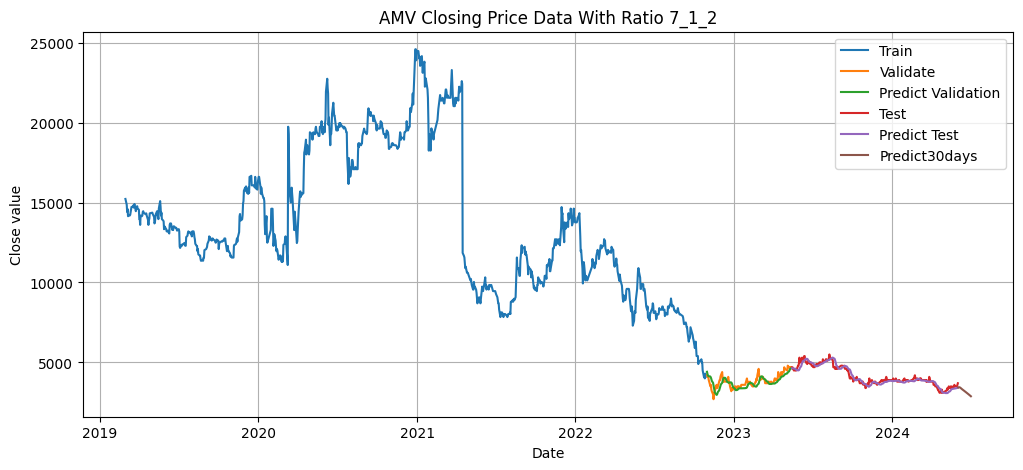

In [49]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(df[:train_size].index, train_data)
plt.plot(df[train_size:train_size + val_size].index, val_data)
plt.plot(df[train_size:train_size + val_size].index, y_pred_val)
plt.plot(df[train_size + val_size:].index, test_data)
plt.plot(df[train_size + val_size:].index, y_pred)
plt.plot(pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), y_next_30_days)
plt.legend(['Train', 'Validate', 'Predict Validation', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("AMV Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RNN_712_AMV.png')
plt.show()